In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
import gc

In [3]:
os.chdir('/home/luke/Desktop/kaggle/Home_Credit_Default_Risk')
application_test = pd.read_csv('application_test.csv')
application_train = pd.read_csv('application_train.csv')
#bureau = pd.read_csv('bureau.csv')
#bureau_balance = pd.read_csv('bureau_balance.csv')
#credit_card_balance = pd.read_csv('credit_card_balance.csv')
#installments_payments = pd.read_csv('installments_payments.csv')
#POS_CASH_balance = pd.read_csv('POS_CASH_balance.csv')
#previous_application = pd.read_csv('previous_application.csv')

In [3]:
for names in ['application_test','application_train','bureau','bureau_balance','credit_card_balance','installments_payments','POS_CASH_balance','previous_application']:
    print('Size of', names,'is',eval(names).shape)

Size of application_test is (48744, 121)
Size of application_train is (307511, 122)
Size of bureau is (1716428, 17)
Size of bureau_balance is (27299925, 3)
Size of credit_card_balance is (3840312, 23)
Size of installments_payments is (13605401, 8)
Size of POS_CASH_balance is (10001358, 8)
Size of previous_application is (1670214, 37)


In [6]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
application_train.columns.values

array(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3',

In [8]:
%matplotlib inline

In [9]:
application_train.TARGET.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

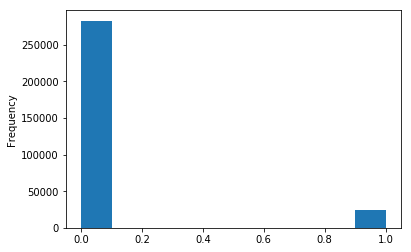

In [10]:
application_train.TARGET.plot.hist()

In [11]:
def missing_values_tables(df):
    
    mis_val = df.isnull().sum()
    mis_val_percent = 100*df.isnull().sum()/len(df)
    mis_val_table = pd.concat([mis_val,mis_val_percent],axis = 1)
    
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0:'Missing Values',1:'% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values',ascending=False).round(1)
    
    print('Your selected dataframe has '+str(df.shape[1])+" columns.\n" "There are " + str(mis_val_table_ren_columns.shape[0])+
         ' column that have missing values.')
    return mis_val_table_ren_columns

In [12]:
missing_values = missing_values_tables(application_train)

Your selected dataframe has 122 columns.
There are 67 column that have missing values.


In [13]:
missing_values

,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [14]:
application_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [15]:
application_train.select_dtypes('object').apply(pd.Series.nunique,axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [4]:
from sklearn.preprocessing import LabelEncoder

In [5]:
le  = LabelEncoder()
le_count = 0

for col in application_train:
    if application_train[col].dtype == 'object':
        if len(list(application_train[col].unique())) <= 2:
            le.fit(application_train[col])
            application_train[col] = le.transform(application_train[col])
            application_test[col] = le.transform(application_test[col])
            
            le_count += 1
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [6]:
application_train = pd.get_dummies(application_train)
application_test = pd.get_dummies(application_test)

In [7]:
train_labels = application_train['TARGET']

In [8]:
application_train,application_test = application_train.align(application_test,join='inner',axis = 1)

print('Training Features Shape: ', application_train.shape)
print('Testing Features Shape: ', application_test.shape)

Training Features Shape:  (307511, 239)
Testing Features Shape:  (48744, 239)


In [9]:
application_train['TARGET'] = train_labels
correlations = application_train.corr()['TARGET'].sort_values()

print('Most Positive Correlations: \n', correlations.tail(15))
print('\nMost Negative Correlations :\n', correlations.head(15))

Most Positive Correlations: 
 DAYS_REGISTRATION                                    0.041975
OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negat

In [22]:
application_train['DAYS_BIRTH'] = abs(application_train['DAYS_BIRTH'])
application_train['DAYS_BIRTH'].corr(application_train['TARGET'])

-0.07823930830982712

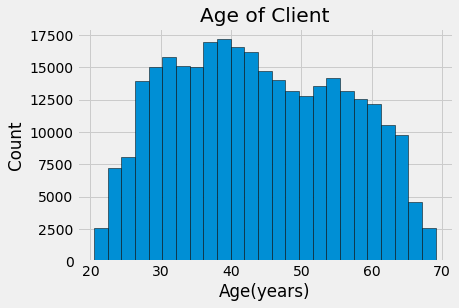

In [23]:
plt.style.use('fivethirtyeight')
plt.hist(application_train['DAYS_BIRTH']/365,edgecolor='k',bins=25)
plt.title('Age of Client'); plt.xlabel('Age(years)'); plt.ylabel('Count');

Text(0.5,1,'Distribution of Ages')

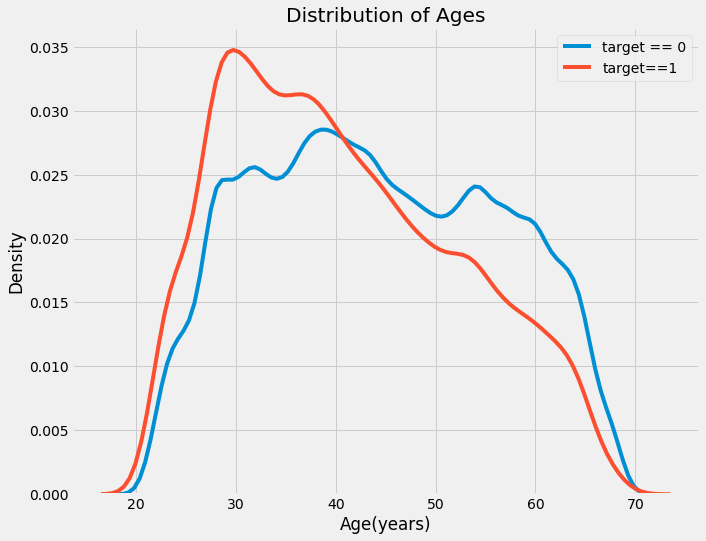

In [24]:
plt.figure(figsize=(10,8))
sns.kdeplot(application_train.loc[application_train['TARGET']==0,'DAYS_BIRTH']/365,label='target == 0')

sns.kdeplot(application_train.loc[application_train['TARGET']==1,'DAYS_BIRTH']/365,label = 'target==1')

plt.xlabel('Age(years)');plt.ylabel('Density');plt.title('Distribution of Ages')

In [25]:
age_data = application_train[['TARGET','DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH']/365

age_data['YEARS_BINNED']= pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20,70,num = 11))
age_data.head(10)

/home/luke/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/luke/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [26]:
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


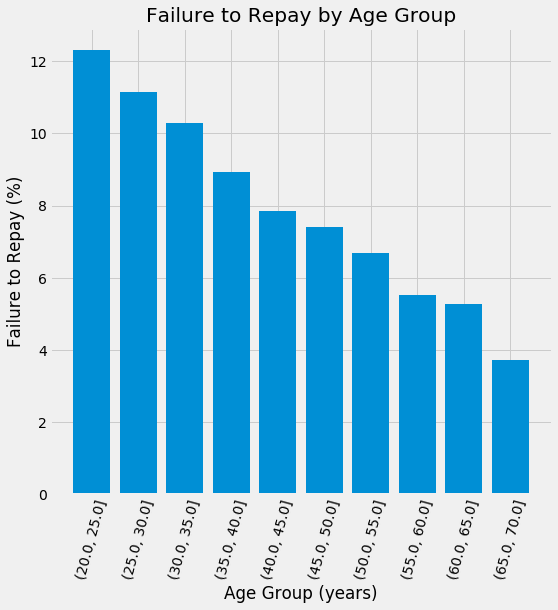

In [27]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

In [9]:
ext_data = application_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,-0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,-0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,-0.205478
DAYS_BIRTH,0.078239,-0.600610,-0.091996,-0.205478,1.000000


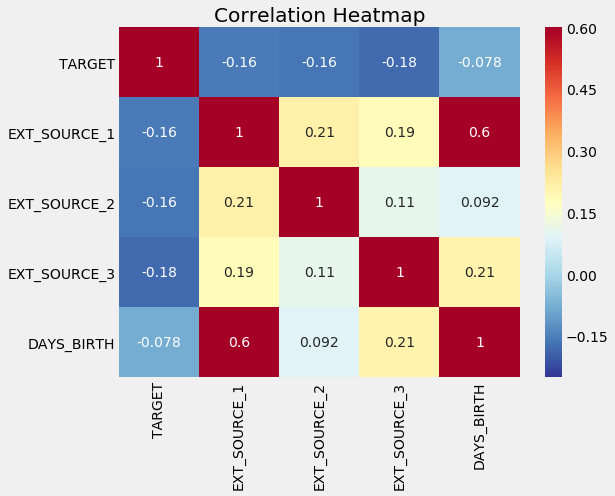

In [29]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

In [10]:
# Make a new dataframe for polynomial features
poly_features = application_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = application_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [11]:
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


In [12]:
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2']

In [13]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
EXT_SOURCE_3                             -0.155892
EXT_SOURCE_1 EXT_SOURCE_3^2              -0.150822
Name: TARGET, dtype: float64
EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH    0.155891
EXT_SOURCE_2 DAYS_BIRTH                 0.156873
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH    0.181283
TARGET                                  1.000000
1                                            NaN
Name: TARGET, dtype: float64


In [14]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = application_train['SK_ID_CURR']
app_train_poly = application_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = application_test['SK_ID_CURR']
app_test_poly = application_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

# Print out the new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

Training data with polynomial features shape:  (307511, 274)
Testing data with polynomial features shape:   (48744, 274)


In [15]:
from sklearn.preprocessing import MinMaxScaler, Imputer

# Drop the target from the training data
if 'TARGET' in application_train:
    train = application_train.drop(columns = ['TARGET'])
else:
    train = application_train.copy()
features = list(train.columns)

# Copy of the testing data
test = application_test.copy()

# Median imputation of missing values
imputer = Imputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(application_test)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 239)
Testing data shape:  (48744, 239)


In [16]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(train, train_labels)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [17]:
log_reg_pred = log_reg.predict_proba(test)[:, 1]

In [38]:
submit = application_test[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred

submit.head()

/home/luke/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,SK_ID_CURR,TARGET
0,100001,0.087895
1,100005,0.163376
2,100013,0.110105
3,100028,0.076499
4,100038,0.155235


In [39]:
submit.to_csv('log_reg_baseline.csv', index = False)

In [18]:
# Format the training and testing data 
train = np.array(application_train.drop(columns = 'TARGET'))
test = np.array(application_test)

train_labels = np.array(train_labels).reshape((-1, ))

# 10 fold cross validation
folds = KFold(n_splits=5, shuffle=True, random_state=50)

# Validation and test predictions
valid_preds = np.zeros(train.shape[0])
test_preds = np.zeros(test.shape[0])

# Iterate through each fold
for n_fold, (train_indices, valid_indices) in enumerate(folds.split(train)):
    # Training data for the fold
    train_fold, train_fold_labels = train[train_indices, :], train_labels[train_indices]
    
    # Validation data for the fold
    valid_fold, valid_fold_labels = train[valid_indices, :], train_labels[valid_indices]
    
    # LightGBM classifier with hyperparameters
    clf = LGBMClassifier(
        n_estimators=10000,
        learning_rate=0.1,
        subsample=.8,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2
    )
    
    # Fit on the training data, evaluate on the validation data
    clf.fit(train_fold, train_fold_labels, 
            eval_set= [(train_fold, train_fold_labels), (valid_fold, valid_fold_labels)], 
            eval_metric='auc', early_stopping_rounds=100, verbose = False
           )
    
    # Validation preditions
    valid_preds[valid_indices] = clf.predict_proba(valid_fold, num_iteration=clf.best_iteration_)[:, 1]
    
    # Testing predictions
    test_preds += clf.predict_proba(test, num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
    
    # Display the performance for the current fold
    print('Fold %d AUC : %0.6f' % (n_fold + 1, roc_auc_score(valid_fold_labels, valid_preds[valid_indices])))
    
    # Delete variables to free up memory
    del clf, train_fold, train_fold_labels, valid_fold, valid_fold_labels
    gc.collect()
    

# Make a submission dataframe
submission = application_test[['SK_ID_CURR']]
submission['TARGET'] = test_preds


Fold 1 AUC : 0.755236
Fold 2 AUC : 0.757236
Fold 3 AUC : 0.762423
Fold 4 AUC : 0.757265
Fold 5 AUC : 0.758051


/home/luke/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [42]:
submission.to_csv("light_gbm_baseline.csv", index=False)


In [43]:
from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50)

In [47]:
# Train on the training data
random_forest.fit(train, train_labels)

# Make predictions on the test data
predictions = random_forest.predict_proba(test)[:, 1]

In [48]:
# Make a submission dataframe
submit = application_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_baseline.csv', index = False)

/home/luke/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [49]:
# Function to calculate and show feature importances
def show_feature_importances(model, features):
    plt.figure(figsize = (12, 8))
    # Dataframe of feature importances sorted from most to least
    results = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
    results = results.sort_values('importance', ascending = False)
    
    # Display
    print(results.head(10))
    print('\nNumber of features with importance greater than 0.01 = ', np.sum(results['importance'] > 0.01))
    
    # Plot of feature importances as horizontal bar chart
    results.head(20).plot(x = 'feature', y = 'importance', kind = 'barh',
                     color = 'red', edgecolor = 'k', title = 'Feature Importances');
    return results

                   feature  importance
32            EXT_SOURCE_2    0.050268
33            EXT_SOURCE_3    0.046797
10              DAYS_BIRTH    0.032366
13         DAYS_ID_PUBLISH    0.032131
12       DAYS_REGISTRATION    0.031494
0               SK_ID_CURR    0.030535
7              AMT_ANNUITY    0.028903
81  DAYS_LAST_PHONE_CHANGE    0.028474
11           DAYS_EMPLOYED    0.027869
6               AMT_CREDIT    0.027407

Number of features with importance greater than 0.01 =  19


<Figure size 864x576 with 0 Axes>

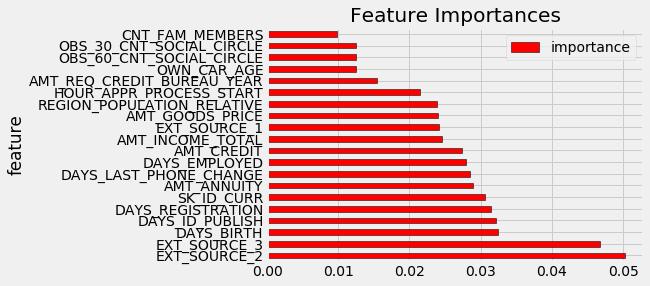

In [50]:
feature_importances = show_feature_importances(random_forest, features)


In [10]:
from keras import models
from keras import layers

In [42]:
y_train = np.array(application_train['TARGET'])

In [43]:
x_val = train[:67511]
partial_x_train = train[67511:]
y_val = y_train[:67511]
partial_y_train = y_train[67511:]

In [44]:
partial_x_train

array([[0.21974552, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.21975113, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.21975675, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.99999439, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.99999719, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [1.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ]])

In [16]:
np.savetxt('x_test.csv',test,delimiter=',')

In [18]:
application_train.shape

(307511, 240)

In [ ]:
np.savetxt("partial_y_train.csv", partial_y_train, delimiter=",")
np.savetxt("partial_x_train.csv", partial_x_train, delimiter=",")

np.savetxt("x_val.csv", x_val, delimiter=",")
np.savetxt("y_val.csv", y_val, delimiter=",")


In [22]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(239,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [23]:
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['accuracy'])

In [3]:
history = model.fit(partial_x_train,partial_y_train,epochs = 10,batch_size=300,validation_data = (x_val,y_val))

NameError: name 'model' is not defined

In [55]:
from keras import optimizers
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
loss='binary_crossentropy',
metrics=['accuracy'])

In [56]:
from keras import losses
from keras import metrics
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
loss=losses.binary_crossentropy,
metrics=[metrics.binary_accuracy])